In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp
import gzip


In [46]:

# One-hot encoding of the labels
def one_hot_encoding(label_data):
    num_classes = len(np.unique(label_data))
    num_labels = label_data.shape[0]
    encoded_labels = np.zeros((num_labels, num_classes))
    encoded_labels[np.arange(num_labels), label_data] = 1
    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(-1, 28*28) # Flatten the normalized pixels
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("./train-images-idx3-ubyte.gz")
    y_train = read_labels("./train-labels-idx1-ubyte.gz")
    X_test = read_pixels("./t10k-images-idx3-ubyte.gz")
    y_test = read_labels("./t10k-labels-idx1-ubyte.gz")
    return X_train, y_train, X_test, y_test



In [47]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  

In [48]:
X_train, y_train, X_test, y_test = read_dataset()
validation_size = 10000

X_val = X_train[:validation_size]
y_val = y_train[:validation_size]

X_train = X_train[validation_size:]
y_train = y_train[validation_size:]

In [50]:
# Initialize weights with Gaussian distribution (N(µ=0, σ=1))
num_classes = y_train.shape[1]
num_samples, num_features = X_train.shape


In [65]:
def compute_accuracy(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)
    return np.mean(predicted_labels == true_labels)


In [56]:
def compute_confusion_matrix(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)
    num_classes = len(np.unique(true_labels))
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(len(true_labels)):
        confusion_matrix[true_labels[i]][predicted_labels[i]] += 1
    return confusion_matrix

def plot_confusion_matrix(conf_matrix):    
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix)

    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(np.arange(num_classes))
    ax.set_yticklabels(np.arange(num_classes))
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, int(conf_matrix[i, j]), ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

In [57]:
# Gradient descent optimizer
costfunc_values = []
def gradient_descent(X, y_true, W, b, learning_rate=5e-4, lambda_reg=1e-4, epochs=100, batch_size=200):
    accuracy_history = []
    m = X.shape[0]
    for epoch in range(epochs):
        for batch_start in range(0, m, batch_size):
            batch_end = batch_start + batch_size
            X_batch = X[batch_start:batch_end]
            y_true_batch = y_true[batch_start:batch_end]
            
            # Forward pass
            linear_pred = np.dot(X_batch, W) + b
            y_hat = softmax(linear_pred)
            
            # Compute gradient with respect to weights (including L2 regularization)
            dw = np.sum(y_hat-y_true_batch) 
            # Update weights
            W -= learning_rate * (np.dot(X_batch.T, y_hat - y_true_batch) + lambda_reg * W)
            b -= learning_rate * dw
        
        #if ( epoch % 10 == 0 ):
            # Evaluate on the validation set
        linear_pred_val = np.dot(X_val, W) + b
        val_predictions = softmax(linear_pred_val)
        val_accuracy = compute_accuracy(val_predictions, y_val)
        val_confusion_matrix = compute_confusion_matrix(val_predictions, y_val)

        accuracy_history.append(val_accuracy)
    linear_pred_test = np.dot(X_test, W) + b
    test_predictions = softmax(linear_pred_test)
    test_accuracy = compute_accuracy(test_predictions, y_test)
    test_confusion_matrix = compute_confusion_matrix(test_predictions, y_test)

    print(f"Test Accuracy: {test_accuracy}")
    print("Confusion Matrix:")
    print(test_confusion_matrix)
    plot_confusion_matrix(test_confusion_matrix)
    
    
    return accuracy_history, test_confusion_matrix


In [58]:
def predict( X, W, b):
        pre_vals = np.dot(X, W) + b
        return softmax(pre_vals)

Q2.1

Test Accuracy: 0.905
Confusion Matrix:
[[ 948    0    3    3    0   10    8    2    5    1]
 [   0 1102    6    2    0    2    3    3   17    0]
 [   9   11  908   25    8    4   23    7   33    4]
 [   3    1   24  899    1   30    4   11   30    7]
 [   2    1    6    6  898    1   13    2   11   42]
 [  10    2    7   35   15  748   18    6   40   11]
 [  16    2   12    1   14   17  885    2    7    2]
 [   2    6   21   13    8    1    0  929    7   41]
 [   8   11    9   28    8   40   10    9  842    9]
 [   8    9    1   10   41   11    1   24   13  891]]


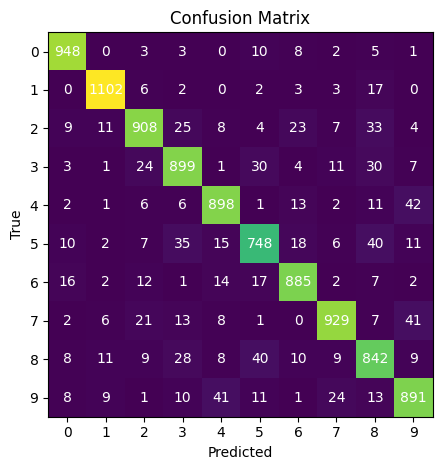

In [73]:
# Train the default model
W = np.random.normal(0, 1, (num_features, num_classes))
b = np.zeros(num_classes)
acc, cm = gradient_descent(X_train, y_train, W, b)




Q2.2

In [66]:
# Gradient descent optimizer
costfunc_values = []
def gradient_descent_val(X, y_true, W, b, learning_rate=5e-4, lambda_reg=1e-4, epochs=100, batch_size=200):
    accuracy_history = []
    m = X.shape[0]
    for epoch in range(epochs):
        for batch_start in range(0, m, batch_size):
            batch_end = batch_start + batch_size
            X_batch = X[batch_start:batch_end]
            y_true_batch = y_true[batch_start:batch_end]
            
            # Forward pass
            linear_pred = np.dot(X_batch, W) + b
            y_hat = softmax(linear_pred)
            
            # Compute gradient with respect to weights (including L2 regularization)
            dw = np.sum(y_hat-y_true_batch) 
            # Update weights
            W -= learning_rate * (np.dot(X_batch.T, y_hat - y_true_batch) + lambda_reg * W)
            b -= learning_rate * dw
        
        #if ( epoch % 10 == 0 ):
            # Evaluate on the validation set
        linear_pred_val = np.dot(X_val, W) + b
        val_predictions = softmax(linear_pred_val)
        val_accuracy = compute_accuracy(val_predictions, y_val)
        val_confusion_matrix = compute_confusion_matrix(val_predictions, y_val)

        accuracy_history.append(val_accuracy)   
    
    return accuracy_history, val_confusion_matrix


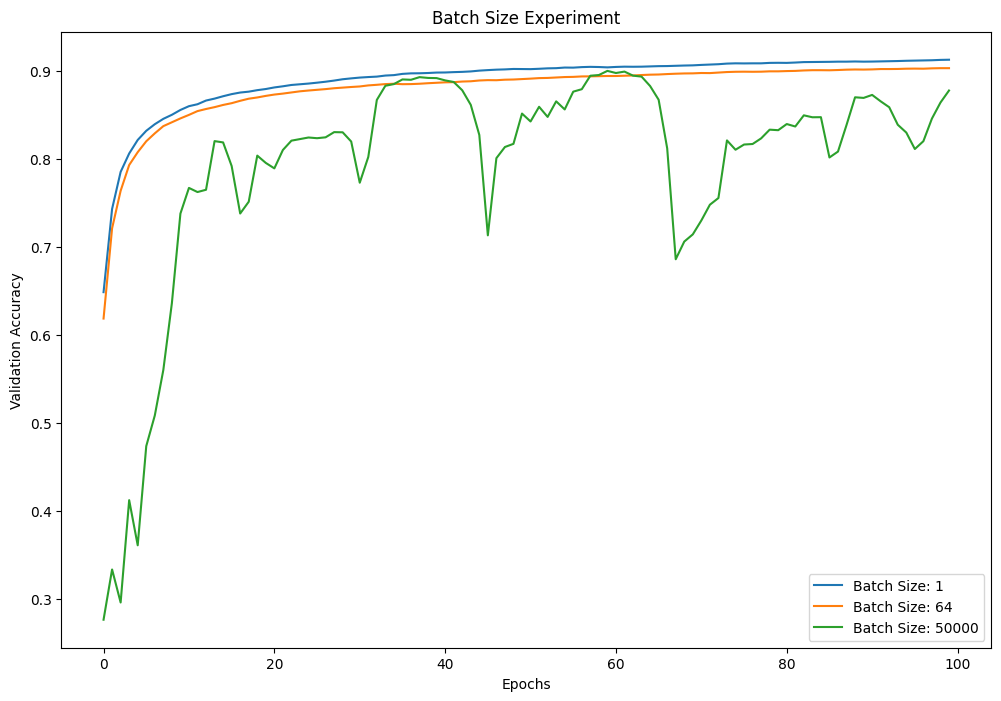

In [72]:
# Experiment on Batch Size
b = np.zeros(num_classes)
# Set hyperparameters
learning_rate = 5e-4
lambda_reg = 1e-4
epochs = 100
batch_sizes = [1, 64, 50000]
plt.figure(figsize=(12, 8))
for batch_size in batch_sizes:
    W = np.random.normal(0, 1, (num_features, num_classes))
    acc, cm = gradient_descent_val(X_train, y_train, W, b, learning_rate, lambda_reg, epochs, batch_size)
    plt.plot(range(0, epochs), acc, label=f'Batch Size: {batch_size}')

plt.title('Batch Size Experiment')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

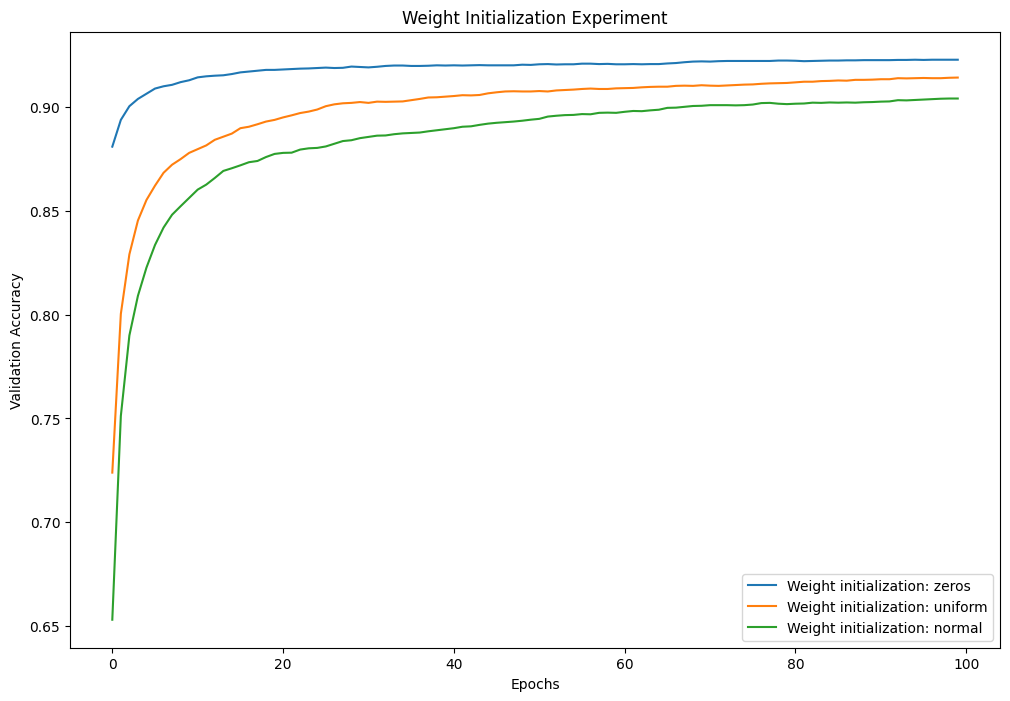

In [69]:
b = np.zeros(num_classes)
# Set hyperparameters
learning_rate = 5e-4
lambda_reg = 1e-4
epochs = 100
batch_size = 200

zeros = np.zeros(shape=(num_features, num_classes))
uniform = np.random.uniform(-1, 1, size=(num_features, num_classes))
normal = np.random.normal(0, 1, size=(num_features, num_classes))

initializations = {
    'zeros': zeros,
    'uniform': uniform,
    'normal': normal,
}
plt.figure(figsize=(12, 8))

# Example loop
for key in initializations:
    W = initializations[key]
    acc, cm = gradient_descent_val(X_train, y_train, W, b, learning_rate, lambda_reg, epochs, batch_size)
    plt.plot(range(0, epochs), acc, label=f'Weight initialization: {key}')

plt.title('Weight Initialization Experiment')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

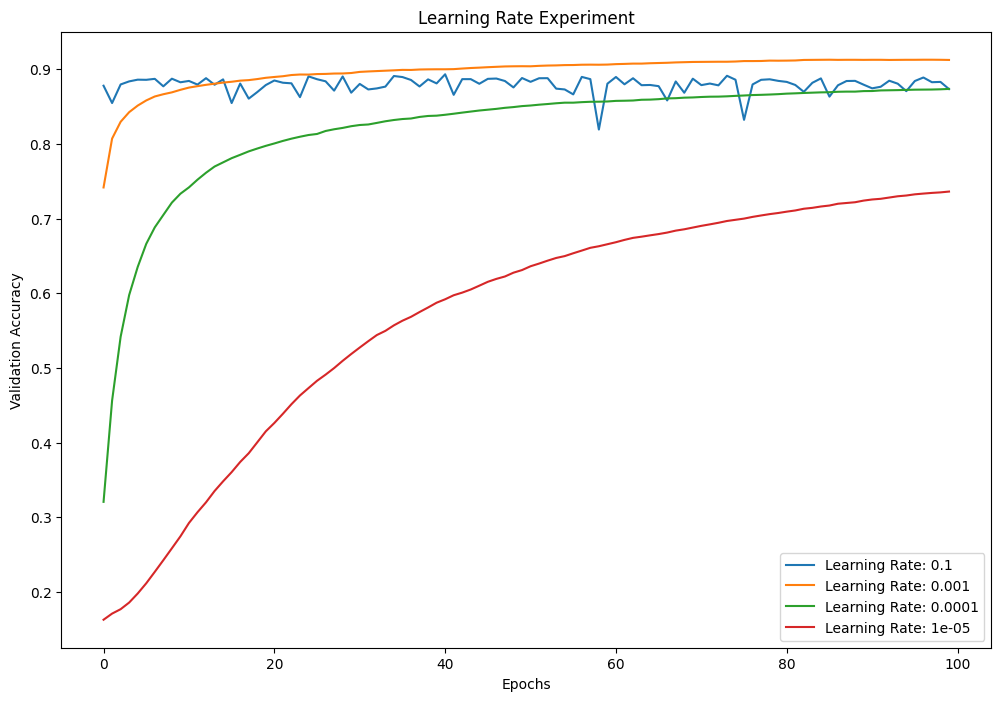

In [70]:
# Experiment on Learning Rate
# Set hyperparameters
batch_size = 200
lambda_reg = 1e-4
epochs = 100
learning_rates = [0.1, 1e-3, 1e-4, 1e-5]
plt.figure(figsize=(12, 8))
for lr in learning_rates:
    W = np.random.normal(0, 1, (num_features, num_classes))
    b = np.zeros(num_classes)
    acc, cm = gradient_descent_val(X_train, y_train, W, b, lr, lambda_reg, epochs, batch_size)
    plt.plot(range(0, epochs), acc, label=f'Learning Rate: {lr}')

plt.title('Learning Rate Experiment')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

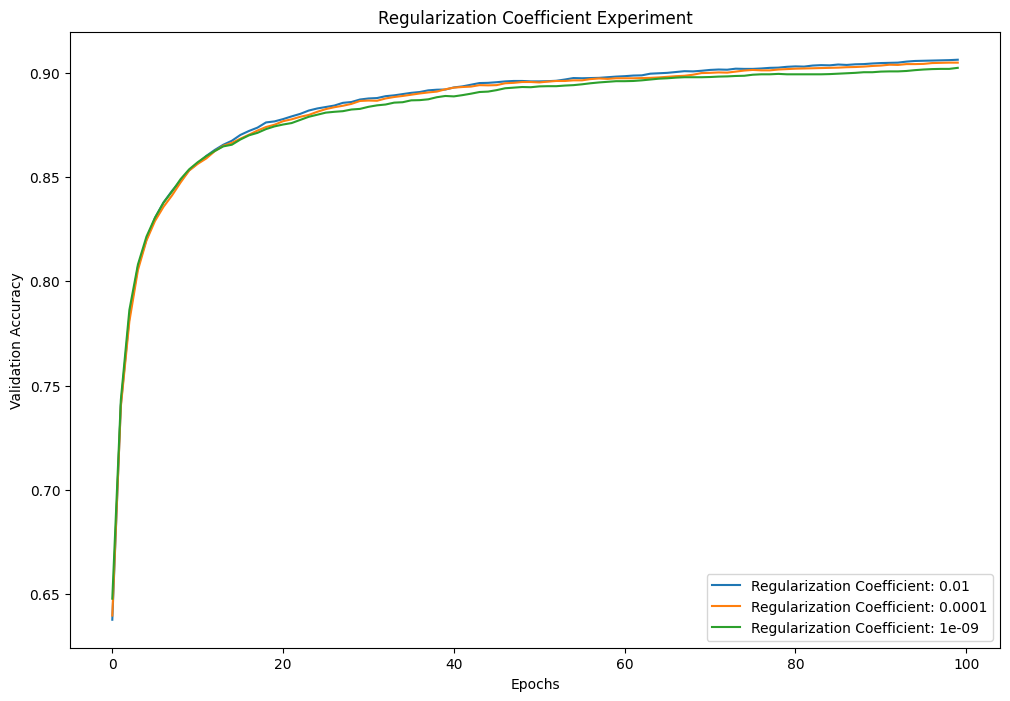

In [71]:
# Experiment on Regularization Coefficient (lambda_reg)
# Set hyperparameters
batch_size = 200
lambda_reg = 1e-4
epochs = 100
learning_rate = 5e-4
lambda_regs = [1e-2, 1e-4, 1e-9]
plt.figure(figsize=(12, 8))
for reg in lambda_regs:
    W = np.random.normal(0,1, (num_features, num_classes))
    b = np.zeros(num_classes)
    acc, cm = gradient_descent_val(X_train, y_train, W, b, learning_rate, reg, epochs, batch_size)
    plt.plot(range(0, epochs), acc, label=f'Regularization Coefficient: {reg}')

plt.title('Regularization Coefficient Experiment')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

Q2.3

Test Accuracy: 0.9227
Confusion Matrix:
[[ 963    0    0    3    0    5    3    3    3    0]
 [   0 1112    2    3    0    1    4    2   11    0]
 [   7   11  914   16    7    4   14   11   43    5]
 [   4    0   16  910    0   31    3   11   26    9]
 [   1    1    5    2  905    0   11    3    9   45]
 [   9    3    2   31    9  778   13    7   33    7]
 [   9    3    3    2    7   21  907    2    4    0]
 [   1    7   20    7    5    1    0  946    4   37]
 [   8    9    4   23    8   30   10   10  860   12]
 [  10    7    1    8   21    7    0   15    8  932]]


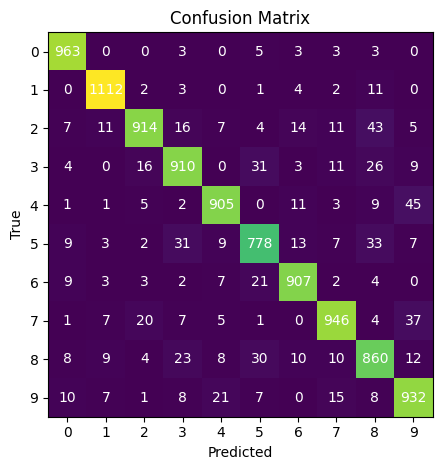

In [61]:
#select the best values for each of the hyperparameters
batch_size = 1
lambda_reg = 1e-4
learning_rate = 1e-3
lambda_regs = 1e-2
b = np.zeros(num_classes)
W = np.zeros(shape=(num_features, num_classes))
acc, conf_matrix = gradient_descent(X_train, y_train, W, b, learning_rate, lambda_reg)


Q2.4

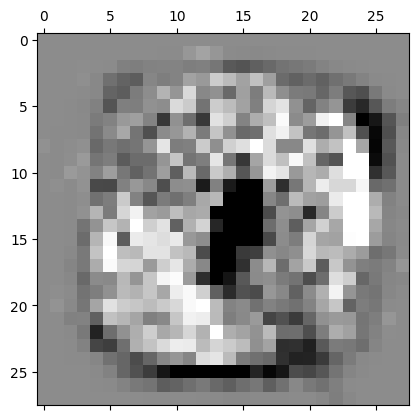

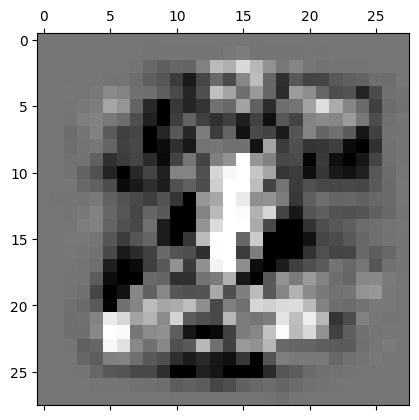

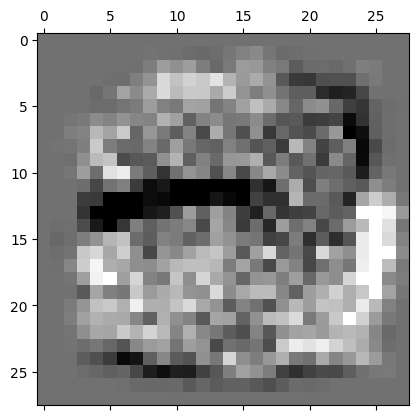

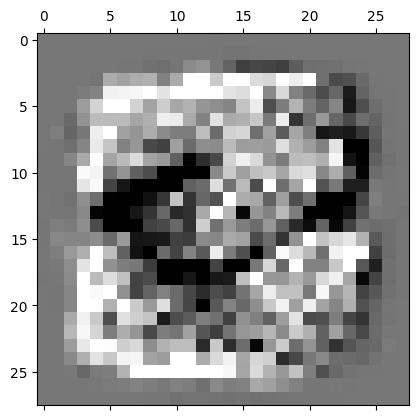

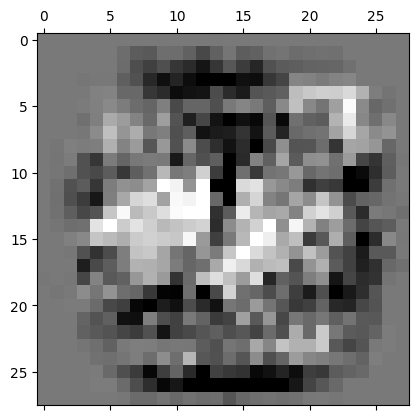

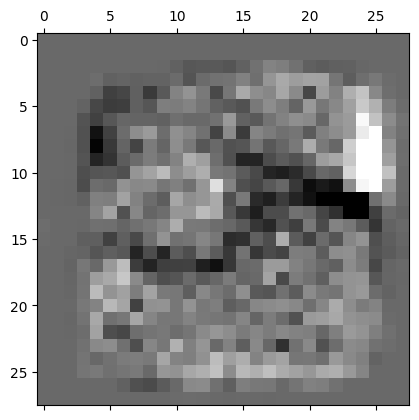

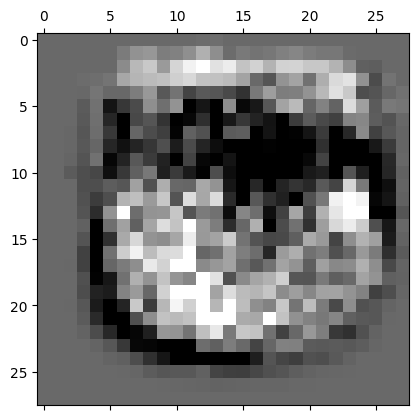

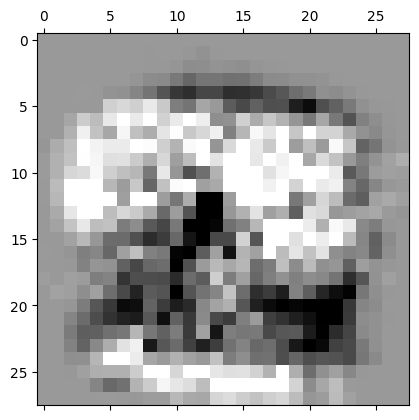

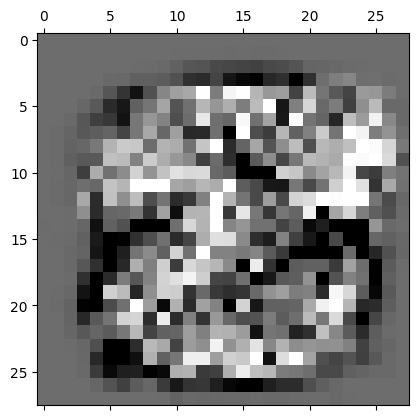

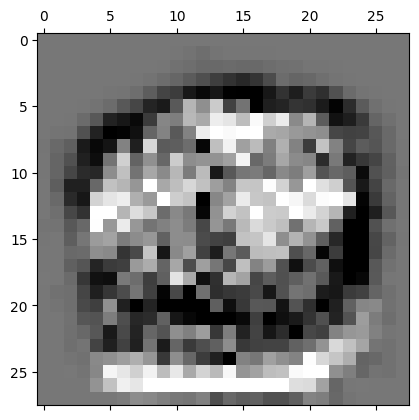

In [62]:

# For Question 2.4
# Code to visualize weights (use your own weight variable, adjust its shape by yourself)

for weight in W.T:
    plt.matshow(weight.reshape(28, 28), cmap=plt.cm.gray, vmin=0.5 * weight.min(), vmax=0.5 * weight.max())
    plt.show()

Q2.5

In [63]:
def calculate_metrics(confusion_matrix):
    # Calculate precision, recall, F1, and F2 scores
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    
    # Avoid division by zero for precision and recall
    precision[np.isnan(precision)] = 0
    recall[np.isnan(recall)] = 0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Calculate F2 score with beta = 2
    beta = 2
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    
    return precision, recall, f1_score, f2_score

In [64]:
precision, recall, f1, f2 = calculate_metrics(conf_matrix)
for i in range(num_classes):
    
    print("Class", i, "Precision:", precision[i])
    print("Class", i, "Recall:", recall[i])
    print("Class", i, "F1 Score:", f1[i])
    print("Class", i, "F2 Score:", f2[i])
    print()

Class 0 Precision: 0.9515810276679841
Class 0 Recall: 0.9826530612244898
Class 0 F1 Score: 0.9668674698795181
Class 0 F2 Score: 0.9762773722627739

Class 1 Precision: 0.9644405897658282
Class 1 Recall: 0.9797356828193833
Class 1 F1 Score: 0.9720279720279721
Class 1 F2 Score: 0.9766379764623222

Class 2 Precision: 0.9451913133402275
Class 2 Recall: 0.8856589147286822
Class 2 F1 Score: 0.9144572286143071
Class 2 F2 Score: 0.8969578017664377

Class 3 Precision: 0.9054726368159204
Class 3 Recall: 0.900990099009901
Class 3 F1 Score: 0.903225806451613
Class 3 F2 Score: 0.9018830525272548

Class 4 Precision: 0.9407484407484408
Class 4 Recall: 0.9215885947046843
Class 4 F1 Score: 0.9310699588477367
Class 4 F2 Score: 0.9253578732106339

Class 5 Precision: 0.8861047835990888
Class 5 Recall: 0.8721973094170403
Class 5 F1 Score: 0.8790960451977401
Class 5 F2 Score: 0.8749437696806116

Class 6 Precision: 0.9398963730569948
Class 6 Recall: 0.9467640918580376
Class 6 F1 Score: 0.9433177327093084
Clas